# Bayes Final Project

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from pymc3 import HalfCauchy, Model, Normal, sample, MvNormal 
import xarray as xr
import graphviz
import scipy
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import arviz as az
az.style.use('arviz-darkgrid')
import theano.tensor as tt
import theano

In [2]:
! pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 872 kB 6.4 MB/s 
     |████████████████████████████████| 1.8 MB 37.5 MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=419ef9c6456f572a5b9e0827ca773b584c720bfb28011a59c9e6a798f3ba29e8
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built theano-pymc


In [34]:
data = pd.read_csv('diabetes')
data = data.drop(['Unnamed: 0'], axis=1)

In [7]:
data.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,1.0,1.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,1.0,1.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,1.0,0.0,0.0,0.0,11.0,5.0,4.0


In [8]:
data['Diabetes_012'].value_counts()

0.0    159394
2.0     26123
1.0      3485
Name: Diabetes_012, dtype: int64

In [9]:
data_test = data.iloc[range(1000),:]

In [31]:
with pm.Model() as model:
    X = theano.shared(data_test.iloc[:,range(1,22)].to_numpy())
    Y = theano.shared(data_test['Diabetes_012'].to_numpy())

    beta = pm.Normal("beta", 0, sigma=1e2, shape=21)
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    p = tt.nnet.softmax(np.dot(X, beta) + alpha)

    observed = pm.Categorical("obs", p=p, observed=Y)

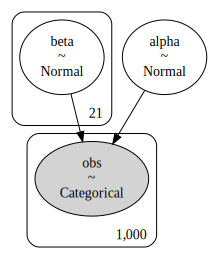

In [32]:
pm.model_to_graphviz(model)

In [33]:
with model:
    model_trace = pm.sample(1000, cores=4)

/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


ERROR:pymc3:There were 872 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 834 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 813 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 879 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [35]:
advi_fit = pm.fit(500, method='advi', model=model)

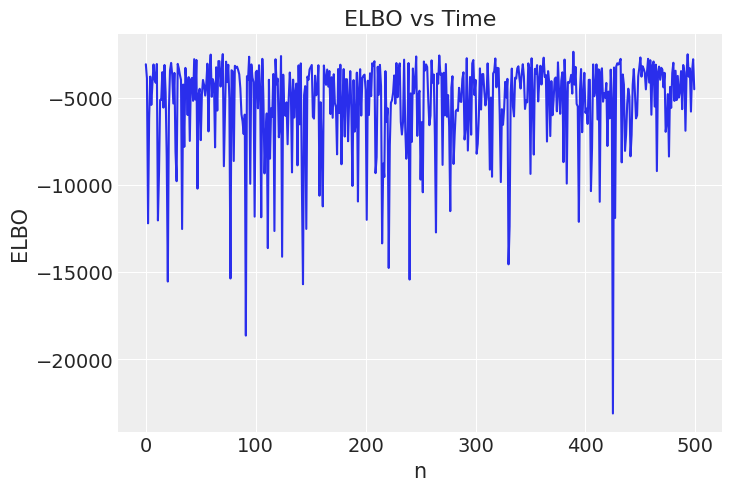

In [36]:
advi_elbo = pd.DataFrame({'ELBO':-advi_fit.hist, 'n': np.arange(advi_fit.hist.shape[0])})
plt.figure(dpi=100)
ax = sns.lineplot(y='ELBO', x='n', data=advi_elbo)
ax.set_title('ELBO vs Time')
plt.show()

In [37]:
advi_trace = advi_fit.sample(1000)

In [38]:
az.summary(advi_trace, var_names=['alpha', 'beta'], round_to=2)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.01,0.79,-1.42,1.46,0.03,0.02,950.49,949.64,NaN
beta[0],0.14,0.65,-1.05,1.39,0.02,0.01,1078.66,881.39,NaN
beta[1],0.00,0.67,-1.21,1.24,0.02,0.02,1064.14,952.63,NaN
beta[2],0.17,0.70,-1.09,1.56,0.02,0.02,917.19,1025.21,NaN
beta[3],-0.11,0.67,-1.36,1.14,0.02,0.02,813.84,875.49,NaN
beta[4],-0.11,0.69,-1.37,1.20,0.02,0.02,1004.22,842.41,NaN
beta[5],-0.12,0.76,-1.53,1.31,0.02,0.02,1006.26,959.75,NaN
beta[6],-0.05,0.72,-1.30,1.34,0.02,0.02,1008.19,852.94,NaN
beta[7],-0.12,0.66,-1.32,1.12,0.02,0.02,915.72,844.16,NaN
beta[8],-0.14,0.68,-1.41,1.12,0.02,0.01,1071.43,943.03,NaN


ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd1d81fed0>],
      dtype=object)

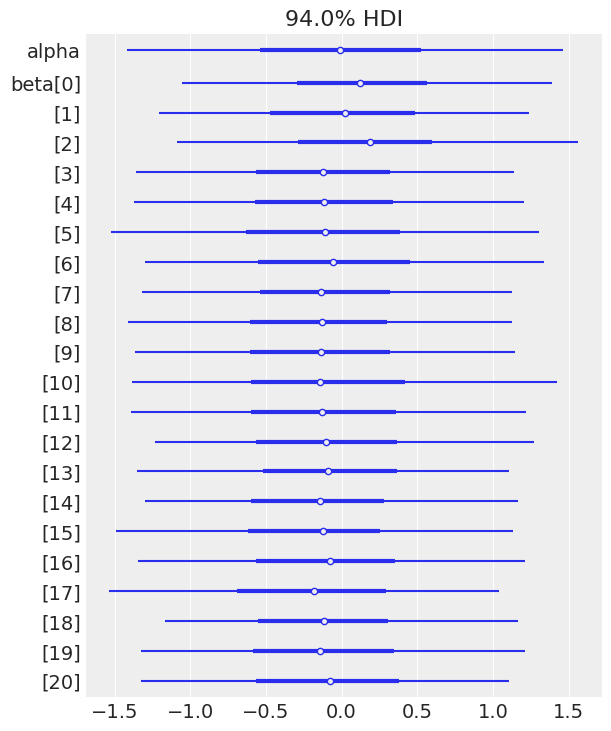

In [39]:
az.plot_forest(advi_trace,  var_names=['alpha', 'beta'])

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


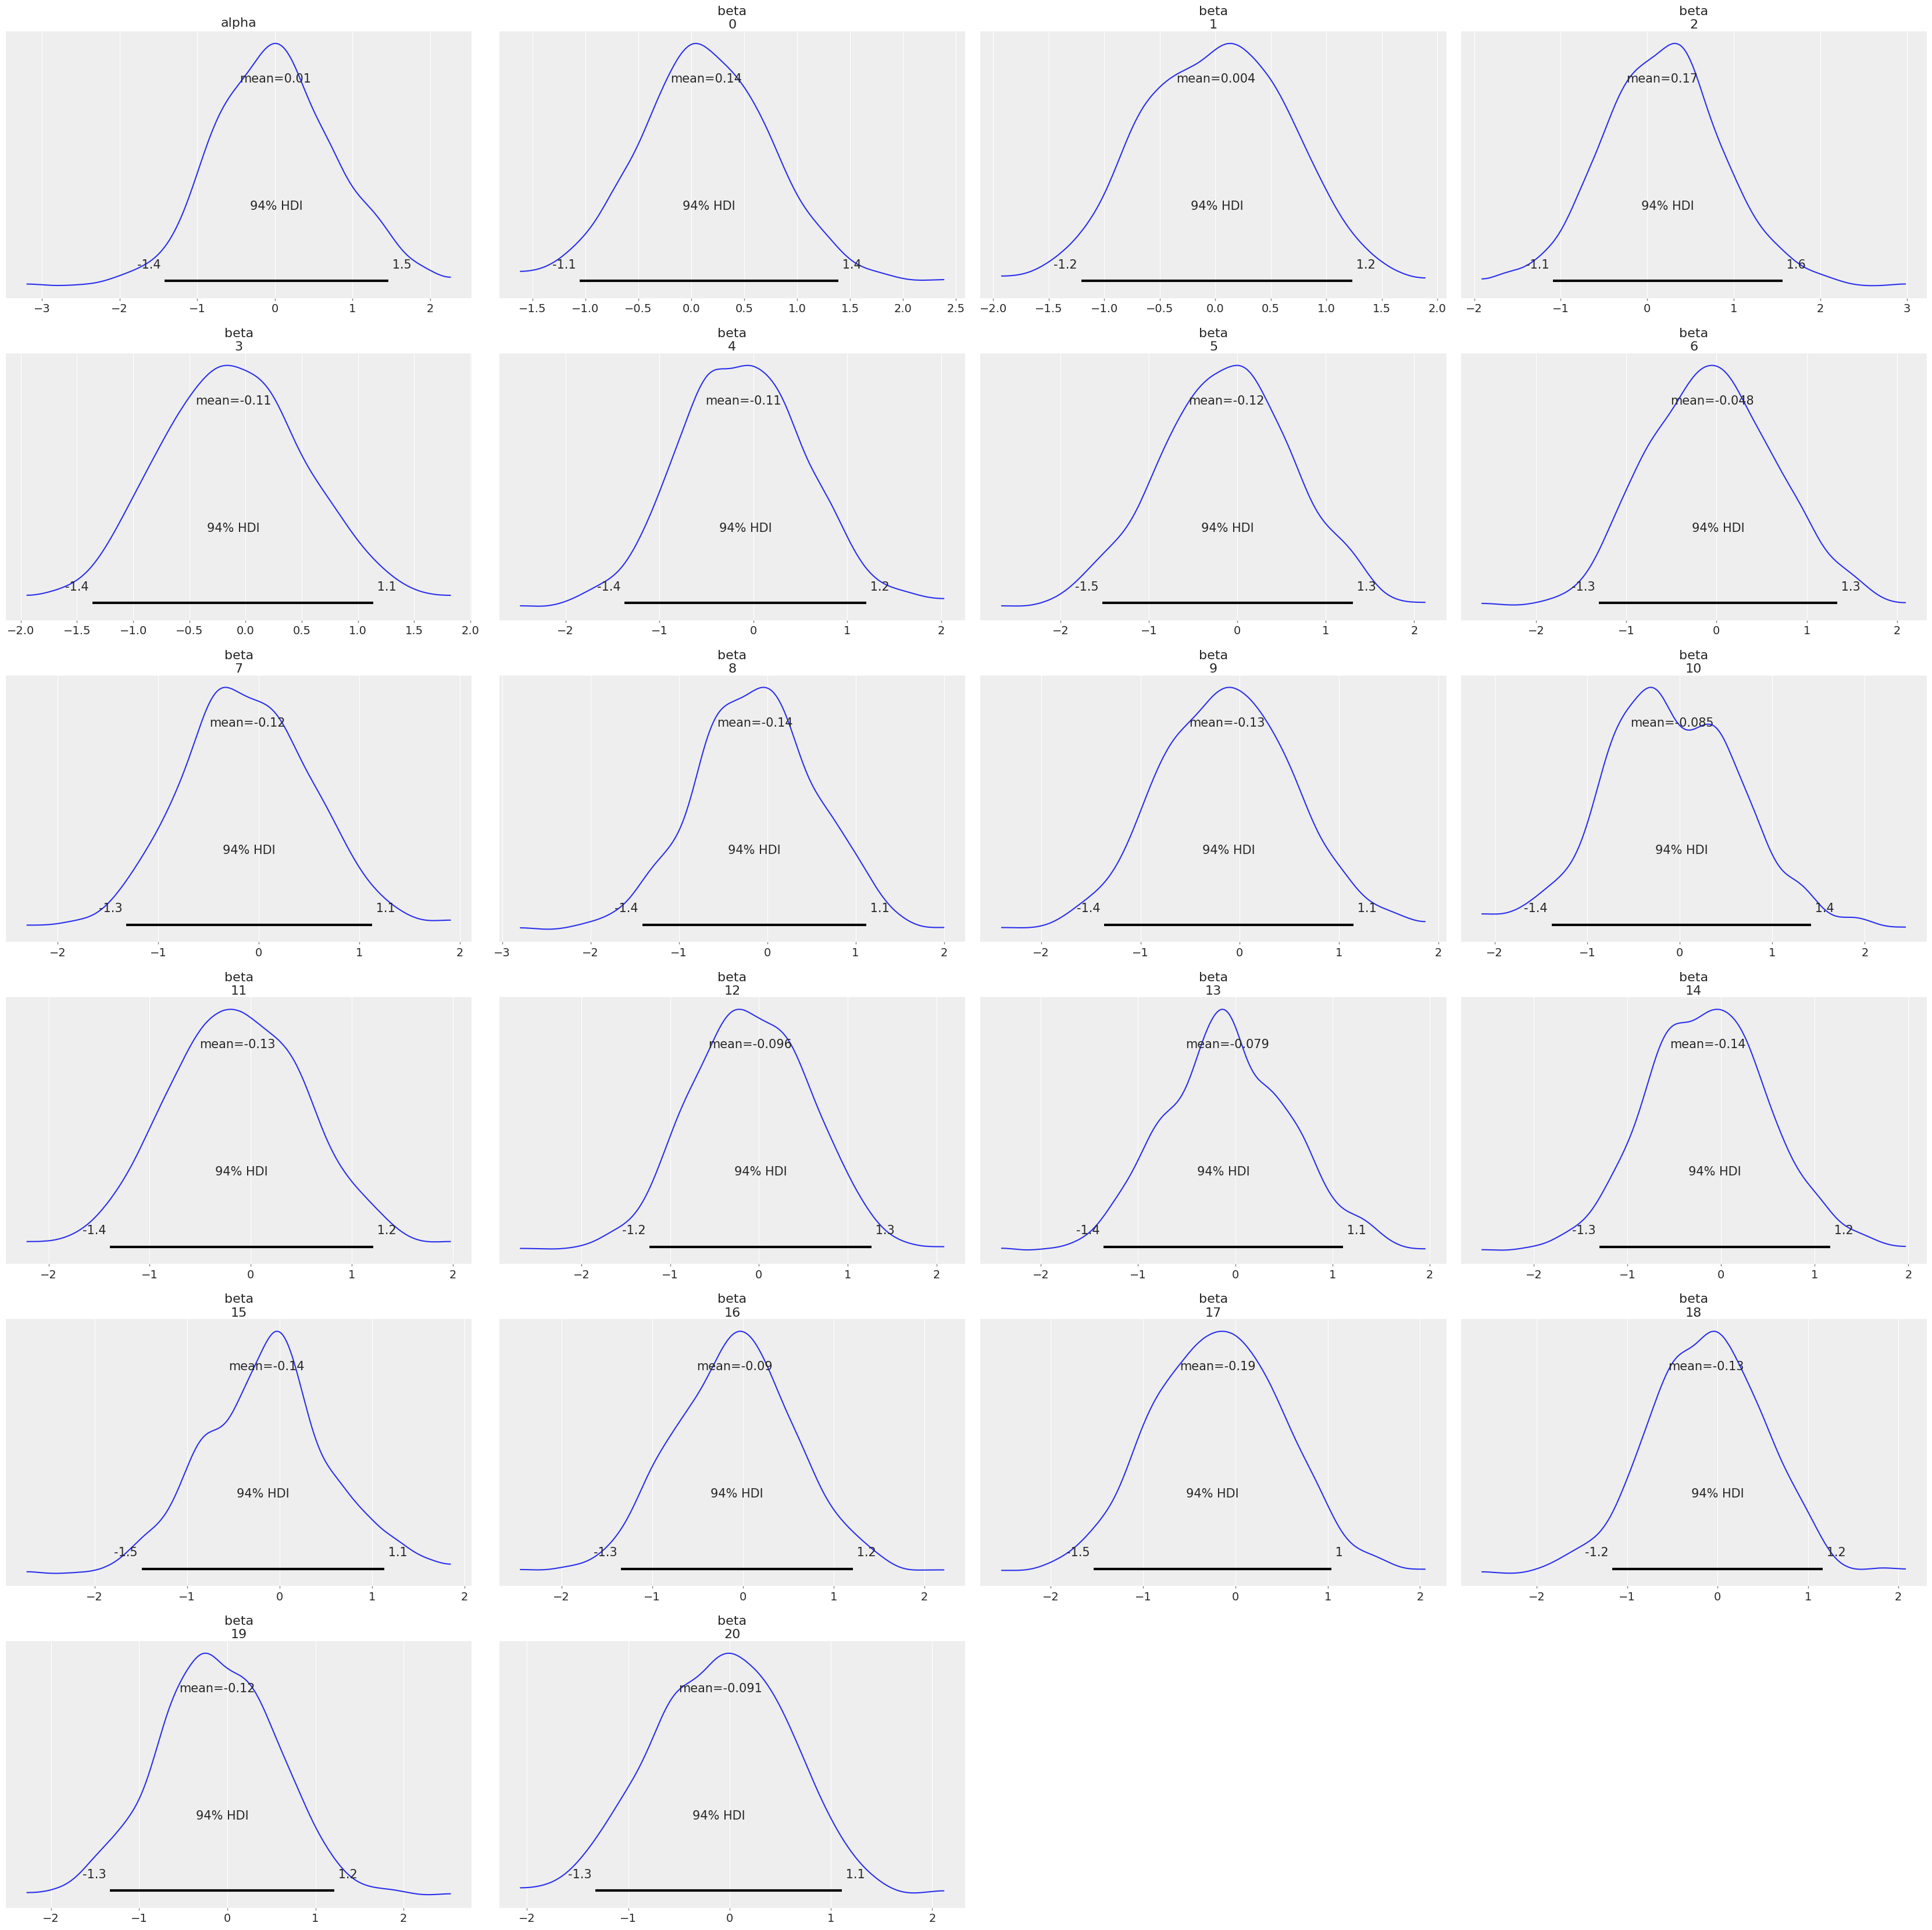

In [40]:
az.plot_posterior(advi_trace, var_names=['alpha', 'beta'])
plt.show()

In [41]:
with pm.Model() as model2:
    Y = theano.shared(data_test['Diabetes_012'].to_numpy())
    X = theano.shared(data_test.iloc[:,range(1,22)].to_numpy())
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    mu = alpha + pm.math.dot(X, beta)
    p = pm.Deterministic('p', tt.nnet.softmax(mu))
    Y1 = pm.Categorical('obs', p=p, observed=Y)

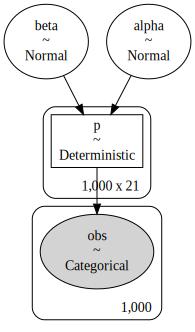

In [42]:
pm.model_to_graphviz(model2)